# Backpropagation algorithm

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import matplotlib.pyplot as plt
from IPython.display import display
import datetime as dt 
import random
from back_prop_utils import H_th_function, grid_search, round_to_sig_figs
from loss_functions import loss
from models import TransferFunctionModel

In [2]:
# TODO: Implement this with torch for consistency, make routine for unwrapping with torch/numpy

# frequency range
interp = 2**6
freqs_THz = np.linspace(0.1, 5, interp)   # 0-5 THz 
freqs = freqs_THz * 1e12
freqs_ang = freqs * 2 * np.pi 
w_tensor = torch.tensor(freqs_ang, dtype=torch.float32)

# Generate random n, k, d
n_lims = [2, 4]
k_lims = [-0.1, 0]
d_lims = [300e-6, 500e-6]

# Define significant figures for each parameter
n_sig_figs = 6
k_sig_figs = 6
d_sig_figs = 6

# Generate data point
n = random.uniform(*n_lims)
k = random.uniform(*k_lims)
d = random.uniform(*d_lims)

# Apply significant figures
n_actual = round_to_sig_figs(n, n_sig_figs)
k_actual = round_to_sig_figs(k, k_sig_figs)
d_actual = round_to_sig_figs(d, d_sig_figs)

tf_values = H_th_function((n_actual+k_actual*1j), w_tensor, d_actual)  # Use torch tensor for w

H_values_clean = np.abs(tf_values)
phi_values_clean = np.unwrap(np.angle(tf_values))
phi_exp_tensor = torch.tensor(phi_values_clean, dtype=torch.float32) # convert back to tensor

# add noise or actual signals
H_values = H_values_clean + np.random.normal(0, 0.005, size=len(H_values_clean))
phi_values = phi_exp_tensor + np.random.normal(0, 1, size=len(phi_values_clean))

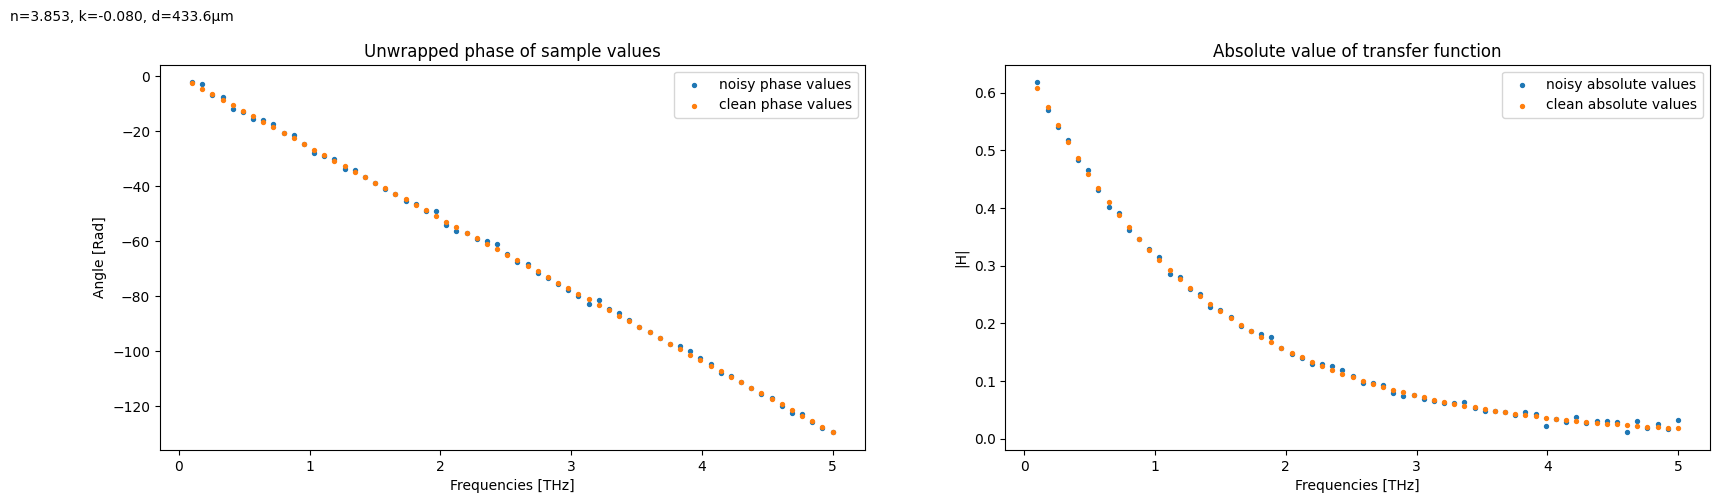

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

axs[0].scatter(freqs_THz, phi_values, s=8, label='noisy phase values')
axs[0].scatter(freqs_THz, phi_values_clean, s=8, label='clean phase values')
axs[0].set_title('Unwrapped phase of sample values')
axs[0].set_xlabel('Frequencies [THz]')
axs[0].set_ylabel('Angle [Rad]')

axs[1].scatter(freqs_THz, H_values, s=8, label='noisy absolute values')
axs[1].scatter(freqs_THz, H_values_clean, s=8, label='clean absolute values')
axs[1].set_title('Absolute value of transfer function')
axs[1].set_xlabel('Frequencies [THz]')
axs[1].set_ylabel('|H|')

# Annotate with n, k, d values
axs[1].set_ylabel('|H|')

# Add a label at the top-left of the entire figure (outside the subplots)
fig.text(0.05, 0.99, f'n={n:.3f}, k={k:.3f}, d={1e6*d:.1f}µm', 
         verticalalignment='top', horizontalalignment='left', 
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'))

axs[0].legend()
axs[1].legend()
plt.show()

In [4]:
# Perform grid-search for params
#grid_search(n0=2.0, k0=-0.05, d0=0.0004, H_values=H_values, phi_values=phi_values, freqs_ang=freqs_ang, H_th_function=H_th_function, loss=loss, verbose=True)

## Logarithmic parameterization

## Regular parameterization

In [5]:
# Initialize model and optimizer
model = TransferFunctionModel(w_tensor=w_tensor, d=d_actual) # initialize with frequency range.
optimizer = torch.optim.Adam(model.parameters(), lr=10e-5)

# Training Loop
num_epochs = 10000
loss_plot = [] # store loss values for plotting.
n_vals = []
k_vals = []

l = np.Inf
for epoch in range(num_epochs):

    n_vals.append(model.n.item())
    k_vals.append(model.k.item())

    optimizer.zero_grad()
    
    # Compute predicted transfer function
    H_pred = model()

    # Compute amplitude and phase
    H_pred_amp = torch.abs(H_pred)
    H_pred_phase = torch.angle(H_pred)

    # Unwrap the phase using NumPy
    H_pred_phase_unwrapped = np.unwrap(H_pred_phase.detach().cpu().numpy())  # Convert to NumPy, unwrap, and convert back to tensor

    # Convert the unwrapped phase back to a PyTorch tensor
    H_pred_phase_unwrapped = torch.tensor(H_pred_phase_unwrapped, dtype=torch.float32).to(H_pred.device)

    l = loss(H_values, H_pred_amp, phi_values, H_pred_phase_unwrapped)
    loss_plot.append(l.item())
    
    # Backpropagation
    l.backward()
    optimizer.step()

    # Print progress
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss = {l.item()}")

# Optimized parameters
print(f"Optimized n: {model.n.item()}, k: {model.k.item()}")

Epoch 0: Loss = 19.84631856365684
Epoch 500: Loss = 18.76705432889941
Epoch 1000: Loss = 18.095070748246773
Epoch 1500: Loss = 17.27493175189598
Epoch 2000: Loss = 16.340296433604145
Epoch 2500: Loss = 15.34407155424425
Epoch 3000: Loss = 14.296351635758631
Epoch 3500: Loss = 13.217177651199611
Epoch 4000: Loss = 12.118505072506247
Epoch 4500: Loss = 11.03182974151153
Epoch 5000: Loss = 9.934848667019267
Epoch 5500: Loss = 8.84265943279042
Epoch 6000: Loss = 7.745770459250229
Epoch 6500: Loss = 6.679850387834845
Epoch 7000: Loss = 5.672898542085794
Epoch 7500: Loss = 4.677943778804163
Epoch 8000: Loss = 3.6584958292638277
Epoch 8500: Loss = 2.7109809919104744
Epoch 9000: Loss = 2.1471496353078443
Epoch 9500: Loss = 1.645982127094296
Optimized n: 3.7981584072113037, k: -0.08015737682580948


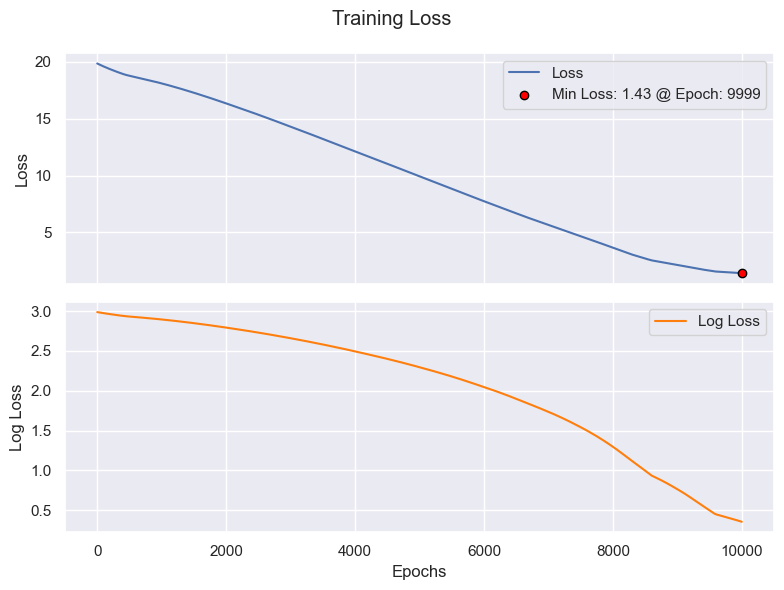

In [6]:
# Define epochs range
epochs = range(len(loss_plot))

# Compute log loss (avoiding log(0) issues)
log_loss = np.log(np.array(loss_plot) + 1e-8)

# Highlight minimum loss point
min_epoch = np.argmin(loss_plot)

# Set Seaborn theme
sns.set_theme(style="darkgrid")

# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Plot raw loss with smoothing
sns.lineplot(x=epochs, y=loss_plot, ax=axs[0], label="Loss")
#axs[0].scatter(epochs, loss_plot, color="tab:blue", s=40, label="Raw Loss", alpha=0.6)
axs[0].scatter(min_epoch, loss_plot[min_epoch], color="red", label=f"Min Loss: {min(loss_plot):.2f} @ Epoch: {min_epoch}", edgecolor="black", zorder=3)
axs[0].set_ylabel("Loss")
axs[0].legend()

# Plot log loss with smoothing
sns.lineplot(x=epochs, y=log_loss, color="tab:orange", ax=axs[1], label="Log Loss")
#axs[1].scatter(epochs, log_loss, color="tab:orange", s=40, label="Raw Log Loss", alpha=0.6)
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Log Loss")
axs[1].legend()



# Add overall title
plt.suptitle("Training Loss")

# Show the plot
plt.tight_layout()
plt.show()

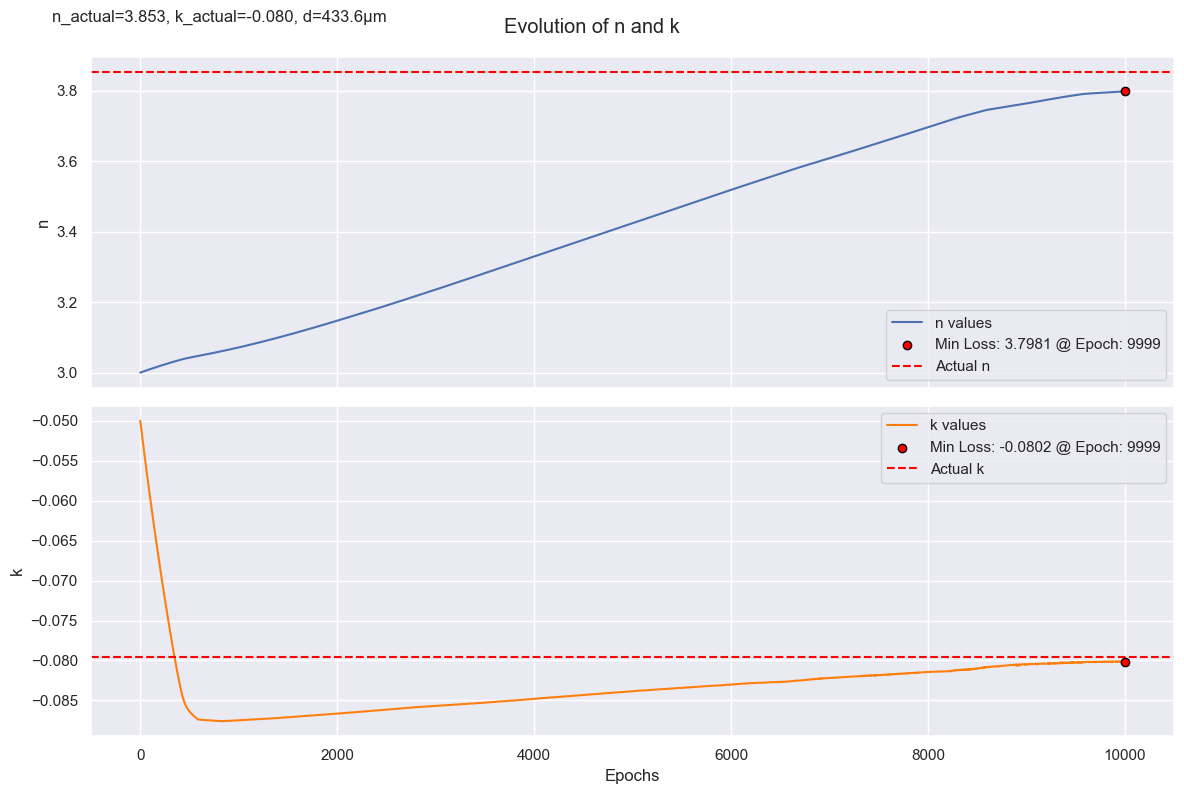

In [10]:
# Set Seaborn theme
sns.set_theme(style="darkgrid")

# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot n values with epochs
sns.lineplot(x=epochs, y=n_vals, ax=axs[0], label="n values")
axs[0].scatter(min_epoch, n_vals[min_epoch], color="red", label=f"Min Loss: {n_vals[min_epoch]:.4f} @ Epoch: {min_epoch}", edgecolor="black", zorder=3)
axs[0].axhline(y=n_actual, color="red", linestyle="--", label="Actual n")  # Add real n value
axs[0].set_ylabel("n")
axs[0].legend()

# Plot k values with epochs
sns.lineplot(x=epochs, y=k_vals, color="tab:orange", ax=axs[1], label="k values")
axs[1].scatter(min_epoch, k_vals[min_epoch], color="red", label=f"Min Loss: {k_vals[min_epoch]:.4f} @ Epoch: {min_epoch}", edgecolor="black", zorder=3)
axs[1].axhline(y=k_actual, color="red", linestyle="--", label="Actual k")  # Add real k value
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("k")
axs[1].legend()

# Add overall title
plt.suptitle("Evolution of n and k")

# Add a label at the top-left of the entire figure (outside the subplots)
fig.text(0.05, 0.99, f'n_actual={n:.3f}, k_actual={k:.3f}, d={1e6*d:.1f}µm', 
         verticalalignment='top', horizontalalignment='left', 
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'))

# Show the plot
plt.tight_layout()
plt.show()

In [8]:
# TODO: 
# Test the outputs by plotting.
# Test different initial conditions and create fractals?
# Implement min loss search / early stopping / learning schedule.
# Explore n convergence (seems to be over reducing)